<div align='center'>
<font size="5"><strong>Wikipedia Pageviews Project</strong></font>
<br />
<i>Netanel Madmoni</i>
<br />
<strong><i><large>Part 2: Pattern Classification</large></i></strong>
</div>


----------------

In [419]:
# imports
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import json
import seaborn as sns
from rich import print
import time
from numba import njit
import seaborn as sns
from itertools import combinations_with_replacement

sns.set_style('dark')

load_dotenv()


True

In [4]:
RAW_DATA_DIR = Path(os.getenv('RAW_DATA_DIR'))
PROCESSED_DATA_DIR = Path(os.getenv('PROCESSED_DATA_DIR'))
RANDOM_SEED = 42

## Patterns

An interesting area to explore in the page views data set is the unique patterns some pages have.
In this project I decided to focus on the following patterns:
* *One-hit wonder pattern* - a term from the music industry, where a band or an individual become popular due to a single going viral. In this work I am borrowing this term to describe a page of a person that received one big "peak" of views during the lifetime of the page.
* *Nostalgia pattern* - similar to *one-hit wonder*, but here the page received 2 big "peaks" of views during its lifetime, simulating the process of "nostalgia".
* *Seasonal pattern* - where an entity has at least one strong seasonal components in the views its page receives.
* *Rising pattern* - where an entity has an upward trend in its views over time.
* *Fading pattern* - where an entity has an downward trend in its views over time.
* *Constant* - where an entity has no particular pattern in its page views over time.

Below is a visualization of each pattern.

For more details on the classification and the patterns, please refer to the accompanying written report.

In this notebook:
1. I'll classify each entity to have one pattern.
2. I'll analyze the distribution of patterns.

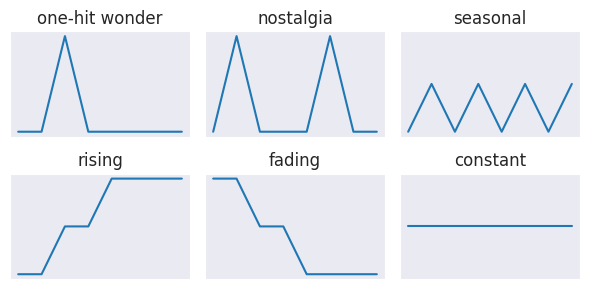

In [15]:
def draw_patterns():
    patterns = {
        'one-hit wonder': [0, 0, 2, 0, 0, 0, 0, 0],
        'nostalgia': [0, 2, 0, 0, 0, 2, 0, 0],
        'seasonal': [0, 1, 0, 1, 0, 1, 0, 1],
        'rising': [0, 0, 1, 1, 2, 2, 2, 2],
        'fading': [2, 2, 1, 1, 0, 0, 0, 0],
        'constant': [1, 1, 1, 1, 1, 1, 1, 1],
        
    }

    fig, axs = plt.subplots(2, len(patterns) // 2, figsize=(len(patterns), 3), sharex=True, sharey=True)
    for (name, pattern), ax in zip(patterns.items(), axs.ravel()):
        sns.lineplot(pattern, ax=ax)
        ax.set(title=name, xticklabels='', yticklabels='')
    plt.tight_layout()
    plt.show()

draw_patterns()

# Reading the Data

In [34]:
views_df = pl.read_parquet(PROCESSED_DATA_DIR / 'pageviews_all.parquet')
info_df = pl.read_parquet(PROCESSED_DATA_DIR / 'people_data_all.parquet')

In [ ]:
views_df

title,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,…,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Neophyte_II_of…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,14,17,26,10,17,24,29,32,51,20,36,46,32,119,27,32,18,26,22,30,30,26,35,33,33,26,25,24,29,44,23,25
"""Olivia_Giovett…",26,34,52,20,41,40,19,21,27,23,32,21,32,29,57,47,31,21,24,15,42,17,45,30,25,34,36,22,22,22,16,28,30,34,22,19,…,39,30,32,34,37,29,14,26,24,36,39,35,20,63,33,39,19,19,30,20,14,21,35,52,25,25,33,20,18,22,31,26,16,20,59,41,19
"""Alexander_Gran…",9,48,24,23,32,24,12,20,19,7,8,14,18,27,11,23,12,19,15,17,11,13,26,14,16,18,13,20,13,26,16,19,32,14,18,12,…,5,13,9,12,11,9,14,19,9,7,5,11,4,11,9,7,9,9,4,5,12,72,6,10,10,10,2,7,10,7,2,7,4,9,10,1,5
"""Bernard_H._Rae…",17,16,21,20,19,18,10,9,17,5,8,10,5,28,19,11,17,14,13,19,16,13,24,18,10,10,14,13,14,19,5,15,26,12,13,10,…,2,1,4,1,5,5,3,5,2,2,3,4,null,12,4,3,2,1,4,null,1,3,8,6,3,1,5,1,3,5,7,3,1,2,null,1,2
"""Leigh_Magar""",47,46,64,36,56,45,41,26,30,48,15,26,19,38,28,38,37,51,24,36,17,15,45,39,26,22,21,14,19,23,16,32,36,21,18,20,…,8,8,9,13,6,3,12,13,12,5,8,8,11,3,9,8,13,13,9,20,9,8,14,27,14,13,20,13,10,9,5,9,9,8,5,10,2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Edgar_Dibden""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,16,6,10,6,7,4,2
"""David_Mulready…",56,51,78,51,54,59,36,44,31,33,29,29,29,54,44,45,23,36,38,35,32,31,42,27,44,33,27,52,29,41,21,36,47,64,37,30,…,16,21,27,33,15,22,31,15,25,16,25,12,25,27,31,18,27,25,20,21,34,15,16,14,15,19,26,19,18,12,7,19,12,14,14,7,6
"""Bruno_Riem""",40,29,34,17,31,29,22,31,14,8,8,16,13,16,7,17,24,16,20,14,14,7,23,16,25,14,13,15,13,20,10,17,31,14,13,12,…,4,9,2,4,5,4,7,8,6,7,8,5,5,4,4,7,2,5,4,11,2,4,5,5,3,5,2,2,4,3,7,5,4,3,3,1,2


In [ ]:
info_df

wikidata_code,birth,death,gender,level1_main_occ,name,un_subregion,level2_main_occ,level3_main_occ,bigperiod_birth,bigperiod_death,sum_visib_ln_5criteria,ranking_visib_5criteria,citizenship_1_b,un_region,bplo1,dplo1,bpla1,dpla1,en_label,en_description,worked_at,educated_at,instrument,genre,birth_month,count_gender,count_instrument,count_worked_at,count_country_of_citizenship,count_educated_at,count_occupation,count_genre
str,i64,i64,str,str,str,str,str,str,str,str,f64,f64,str,str,f64,f64,f64,f64,str,str,list[str],list[str],list[str],list[str],str,u32,u32,u32,u32,u32,u32,u32
"""Q1000005""",1860,1927,"""Male""","""Culture""","""Karel_Matěj_Ča…","""Western Europe…","""Culture-core""","""writer""","""4.Mid Modern P…","""5.Contemporary…",23.98061,131428.0,"""Czech_Republic…","""Europe""",12.929798,14.421389,49.440605,50.087502,"""Karel Matěj Ča…","""Czech writer a…",[],[],[],[],"""02""",1,0,0,1,0,4,0
"""Q100005""",1922,1951,"""Male""","""Culture""","""Tadeusz_Borows…","""Eastern Europe…","""Culture-core""","""writer""","""5.Contemporary…","""5.Contemporary…",28.841227,21473.5,"""Poland""","""Europe""",28.657778,21.01111,50.254444,52.23,"""Tadeusz Borows…","""Polish writer …",[],"[""University of Warsaw""]",[],[],"""11""",1,0,0,1,1,5,0
"""Q1000051""",1884,1962,"""Male""","""Leadership""","""Joseph_C._O'Ma…","""Northern Ameri…","""Politics""","""politician""","""4.Mid Modern P…","""5.Contemporary…",23.15431,170792.0,"""US""","""America""",-71.033333,-77.094643,42.391666,38.984825,"""Joseph C. O'Ma…","""American journ…",[],"[""Georgetown University Law Center"", ""Columbia University""]",[],[],"""11""",1,0,0,1,2,3,0
"""Q1000053""",1962,null,"""Male""","""Leadership""","""Vasily_Nebenzy…","""Eastern Europe…","""Administration…","""diplomat""","""5.Contemporary…","""Missing""",25.141882,230781.0,"""Russia""","""Europe""",44.514721,null,48.708611,null,"""Vasily Nebenzy…","""Russian diplom…","[""United Nations""]","[""Moscow State Institute of International Relations""]",[],[],"""02""",1,0,1,2,1,2,0
"""Q1000061""",1940,null,"""Male""","""Leadership""","""Valentyn_Symon…","""Eastern Europe…","""Politics""","""politician""","""5.Contemporary…","""Missing""",23.340572,219961.0,"""Ukraine""","""Europe""",30.73262,null,46.47747,null,"""Valentyn Symon…","""Ukrainian stat…","[""State University of Trade and Economics""]","[""Odesa State Academy of Civil Engineering and Architecture""]",[],[],"""07""",1,0,1,1,1,2,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q999994""",1988,null,"""Male""","""Sports/Games""","""Mitja_Mežnar""","""Southern Europ…","""Sports/Games""","""ski""","""5.Contemporary…","""Missing""",21.543238,350041.5,"""Slovenia""","""Europe""",14.35561,null,46.238869,null,"""Mitja Mežnar""","""Slovenian ski …",[],[],[],[],"""06""",1,0,0,1,0,1,0
"""Q999995""",1987,null,"""Male""","""Sports/Games""","""Martin_Cikl""","""Western Europe…","""Sports/Games""","""ski""","""5.Contemporary…","""Missing""",21.71133,339942.5,"""Czech_Republic…","""Europe""",14.618354,null,50.911613,null,"""Martin Cikl""","""Czech ski jump…",[],[],[],[],"""08""",1,0,0,1,0,1,0
"""Q999997""",1984,null,"""Male""","""Sports/Games""","""Vincent_Descom…","""Western Europe…","""Sports/Games""","""ski""","""5.Contemporary…","""Missing""",24.453411,154890.0,"""France""","""Europe""",6.868889,null,45.922222,null,"""Vincent Descom…","""French ski jum…",[],[],[],[],"""01""",1,0,0,1,0,2,0


# Determining the Pattern for each Entity

The tools to discover each pattern are as follows:
* *One-hit wonder*, *Nostalgia* -- Symbolic Aggregate ApproXimation (SAX).
* *Seasonal* -- autocorrelation function.
* *Rising*, *Fading* -- Linear regression.
* *Constant* -- anything that doesn't fall into one of the other categories.

Tools are purposely selected to be simple and fast on big data calculations.

Please refer to the accompanying written report for a more detailed explanation of the classification process.

In [167]:
from pyts.approximation import SymbolicAggregateApproximation, PiecewiseAggregateApproximation
from pyts.decomposition import SingularSpectrumAnalysis
from scipy import stats
from statsmodels.tsa.stattools import acf

SAX: https://jmotif.github.io/sax-vsm_site/morea/algorithm/SAX.html

One-hit wonder, nostalgia

In [452]:
@njit
def _count_clusters(x_sax: np.ndarray, d: int):
    if x_sax.ndim != 1:
        raise ValueError('array must be 1d')
    nonzero_count = np.count_nonzero(x_sax) 
    if nonzero_count in (0, 1):
        return nonzero_count

    # Calculate the difference between consecutive indices where 1s occur
    diff = np.diff(np.where(x_sax)[0])

    # Count the number of clusters by checking where the difference is greater than d
    num_clusters = np.sum(diff > d)

    # Add 1 to account for the last cluster
    num_clusters += 1 if len(diff) > 0 else 0

    return num_clusters


def _count_clusters_2d(X_sax: np.ndarray, d: int):
    return np.apply_along_axis(_count_clusters, d=d, arr=X_sax, axis=1).reshape(-1, 1)

def is_one_hit_wonder(X_sax, d: int):
    return _count_clusters_2d(X_sax, d) == 1

def is_nostalgia(X_sax, d: int):
    return _count_clusters_2d(X_sax, d) == 2

Seasonality

In [435]:
def _find_seasonality(x, d):
    lower_bounds = acf(np.diff(x), qstat=True, missing='drop', alpha=.05)[1][d + 1:, 0]
    if lower_bounds.max() < 0:
        return None
    most_significant = (np.argsort(-lower_bounds) + d + 1)[0]
    return most_significant

def find_seasonality_2d(X, d):
    return np.apply_along_axis(_find_seasonality, d=d, arr=X, axis=1).reshape(-1, 1).astype(float)

def is_seasonal(seasonality: np.ndarray):
    return seasonality.astype(bool)

Linear trend

In [301]:
def regression_per_row(X: np.ndarray):
    # normalize X
    X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)
    
    # X range (time)
    m = X.shape[1] - 1
    X_range = np.arange(X.shape[1])
    X_range_mean = m / 2
    
    # slopes, intercepts, residuals
    mean = X.mean(axis=1, keepdims=True)
    slopes = ((X - mean).dot(X_range - X_range_mean) / (m * np.var(X_range))).reshape(-1, 1)
    intercepts = mean - slopes * X_range_mean
    residuals = X - (slopes * X_range + intercepts)
    
    # rss, tss, r2
    rss = np.sum(np.square(residuals), axis=1, keepdims=True)
    tss = np.sum(np.square(X - mean), axis=1, keepdims=True)
    r2s = 1 - rss / tss
    
    # pvalues
    se = X.std(axis=1, keepdims=True) / np.sqrt(np.sum(np.square(X_range - X_range_mean)))
    statistics = slopes / se
    pvs = 2 * (1 - stats.t.cdf(np.abs(statistics), m))
    
    return slopes, intercepts, r2s, pvs
    
def is_rising(slopes: np.ndarray, pvs: np.ndarray):
    return np.logical_and(slopes > 0, pvs > 0.05)

def is_fading(slopes: np.ndarray, pvs: np.ndarray):
    return np.logical_and(slopes < 0, pvs > 0.05)

In [293]:
def get_patterns(views_df: pl.DataFrame, d: int):
    sax_transformer = SymbolicAggregateApproximation(n_bins=2, alphabet='ordinal', strategy='uniform')

    X = views_df.drop('title').fill_null(0).to_numpy()
    X_sax = sax_transformer.transform(X)

    one_hit_wonder = is_one_hit_wonder(X_sax, d)
    nostalgia = is_nostalgia(X_sax, d)
    seasonality = find_seasonality_2d(X, d)
    seasonal = is_seasonal(seasonality)
    slopes, intercepts, r2s, pvs = regression_per_row(X)
    rising = is_rising(slopes, pvs)
    fading = is_fading(slopes, pvs)
    
    return pl.DataFrame([
        views_df['title'],
        pl.Series('is_one_hit_wonder', one_hit_wonder.ravel()),
        pl.Series('is_nostalgia', nostalgia.ravel()),
        pl.Series('seasonality', seasonality.ravel()),
        pl.Series('is_seasonal', seasonal.ravel()),
        pl.Series('is_rising', rising.ravel()),
        pl.Series('is_fading', fading.ravel()),
    ])
    
def add_constant_pattern(patterns_df: pl.DataFrame):
    return patterns_df.with_columns(
                pl.when(pl.any_horizontal('is_one_hit_wonder', 'is_nostalgia', 'is_seasonal', 'is_rising', 'is_fading')).then(False).otherwise(True).alias('is_constant'),        
            )

filename = PROCESSED_DATA_DIR / 'views_patterns.parquet'

try:
    patterns_df = pl.read_parquet(filename)
except FileNotFoundError:
    patterns_df = add_constant_pattern(get_patterns(views_df, d=3))
    patterns_df.write_parquet(filename)

Now let's combine this with the info dataframe.

In [294]:
filename = PROCESSED_DATA_DIR / 'all_info.parquet'
try:
    raise FileNotFoundError
    all_info = pl.read_parquet(filename)
except FileNotFoundError:
    people_data_all = pl.read_parquet(PROCESSED_DATA_DIR / 'people_data_all.parquet')
    all_info = people_data_all.join(add_constant_pattern(patterns_df), left_on='name', right_on='title')
    all_info.write_parquet(filename)
all_info

wikidata_code,birth,death,gender,level1_main_occ,name,un_subregion,level2_main_occ,level3_main_occ,bigperiod_birth,bigperiod_death,sum_visib_ln_5criteria,ranking_visib_5criteria,citizenship_1_b,un_region,bplo1,dplo1,bpla1,dpla1,en_label,en_description,worked_at,educated_at,instrument,genre,birth_month,count_gender,count_instrument,count_worked_at,count_country_of_citizenship,count_educated_at,count_occupation,count_genre,is_one_hit_wonder,is_nostalgia,seasonality,is_seasonal,is_rising,is_fading,is_constant
str,i64,i64,str,str,str,str,str,str,str,str,f64,f64,str,str,f64,f64,f64,f64,str,str,list[str],list[str],list[str],list[str],str,u32,u32,u32,u32,u32,u32,u32,bool,bool,f64,bool,bool,bool,bool
"""Q7088052""",null,null,"""Female""","""Culture""","""Olivia_Giovett…","""Northern Ameri…","""Culture-core""","""author""","""Missing""","""Missing""",15.269195,2.255541e6,"""US""","""America""",null,null,null,null,"""Olivia Giovett…","""journalist""",[],[],[],[],"""01""",1,0,0,1,0,4,0,true,false,NaN,false,true,false,false
"""Q4719004""",1824,1862,"""Male""","""Other""","""Alexander_Gran…","""Oceania Wester…","""Worker/Busines…","""surveyor""","""4.Mid Modern P…","""4.Mid Modern P…",15.934114,1.747964e6,"""Australia""","""Oceania""",null,null,null,null,"""Alexander Gran…","""Surveyor""",[],[],[],[],"""01""",1,0,0,1,0,0,0,false,true,NaN,false,false,false,false
"""Q16067381""",1889,1980,"""Male""","""Leadership""","""Bernard_H._Rae…","""Northern Ameri…","""Politics""","""politician""","""4.Mid Modern P…","""5.Contemporary…",15.606245,1816228.5,"""US""","""America""",null,null,null,null,"""Bernard H. Rae…","""American polit…",[],"[""University of Wisconsin–Eau Claire""]",[],[],"""06""",1,0,0,1,1,1,0,false,false,9.0,true,false,false,false
"""Q16731813""",null,null,"""Female""","""Other""","""Leigh_Magar""",null,"""Worker/Busines…","""milliner""","""Missing""","""Missing""",15.060712,2388995.5,null,null,null,null,null,null,"""Leigh Magar""","""American milli…",[],"[""Fashion Institute of Technology""]",[],[],null,1,0,0,0,1,1,0,false,false,NaN,false,false,false,true
"""Q17486602""",1935,null,"""Male""","""Sports/Games""","""Boncho_Novakov…","""Eastern Europe…","""Sports/Games""","""sport""","""5.Contemporary…","""Missing""",16.396002,1.286861e6,"""Bulgaria""","""Europe""",26.528818,null,43.540894,null,"""Boncho Novakov…","""cyclist""",[],[],[],[],"""05""",1,0,0,1,0,1,0,false,false,NaN,false,false,false,true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q25735""",1973,null,"""Male""","""Sports/Games""","""Milorad_Mažić""","""Southern Europ…","""Sports/Games""","""football""","""5.Contemporary…","""Missing""",27.753937,240783.0,"""Serbia""","""Europe""",19.637777,null,45.569721,null,"""Milorad Mažić""","""Serbian intern…",[],[],[],[],"""03""",1,0,0,1,0,1,0,true,false,NaN,false,false,false,false
"""Q5361773""",1843,1918,"""Male""","""Leadership""","""Elisha_Jessop""","""Northern Ameri…","""Politics""","""politician""","""4.Mid Modern P…","""5.Contemporary…",14.515863,2.640646e6,"""Canada""","""America""",null,null,null,null,"""Elisha Jessop""","""Canadian polit…",[],[],[],[],"""01""",1,0,0,1,0,1,0,false,false,13.0,true,false,false,false
"""Q5237804""",1947,null,"""Male""","""Leadership""","""David_Mulready…","""Oceania Wester…","""Religious""","""priest""","""5.Contemporary…","""Missing""",15.84019,2.156183e6,"""Australia""","""Oceania""",151.210007,null,-33.867779,null,"""David Mulready…","""Australian Ang…",[],"[""Newington College""]",[],[],"""09""",1,0,0,0,1,1,0,false,false,NaN,false,false,false,true


Finally, filter the views dataframe so that only people with information will be retained.

In [273]:
filename = PROCESSED_DATA_DIR / 'views_filtered.parquet'
try:
    views_filtered = pl.read_parquet(filename)
except FileNotFoundError:
    views_filtered = views_df.filter(pl.col('title').is_in(all_info['name']))
    views_filtered.write_parquet(filename)

## Preview For Some Entities

Let's visualize some actual views series and their pattern.

In [291]:
def get_patterns_by_name(name: str, df: pl.DataFrame):
    filtered_df = (df[['name'] + [c for c in df.columns if c.startswith('is')]]
                   .filter(pl.col('name').str.to_lowercase() == name.lower())
    )
    return [pat[0].replace('is_', '') for pat in filtered_df.drop('name').to_dicts()[0].items() if pat[1]]

In [480]:
rng = np.random.default_rng(RANDOM_SEED)

## Random sample
# n_to_plot = 5
# offset = rng.integers(0, views_filtered.height - n_to_plot)
# sample_idx = np.arange(offset, offset + n_to_plot)
# X_all = rng.choice(views_filtered.fill_null(0), n_to_plot, replace=False)

## Sample by names
X_all = (views_filtered.fill_null(0)
         .filter(pl.col('title')
                 .is_in(['Sam_Altman', 'Christopher_Columbus','Taylor_Swift',
                         
                         ]))
                #  .is_in(['bruno_mars', 'vladimir_putin', 'peter_jones_(entrepreneur)', 'robert_frost', 'sam_altman']))
)

X = X_all.to_numpy()[:, 1:]
X_names = X_all.to_numpy()[:, 0]

sax_transformer = SymbolicAggregateApproximation(n_bins=2, alphabet='ordinal', strategy='uniform')
X_sax = sax_transformer.transform(X)

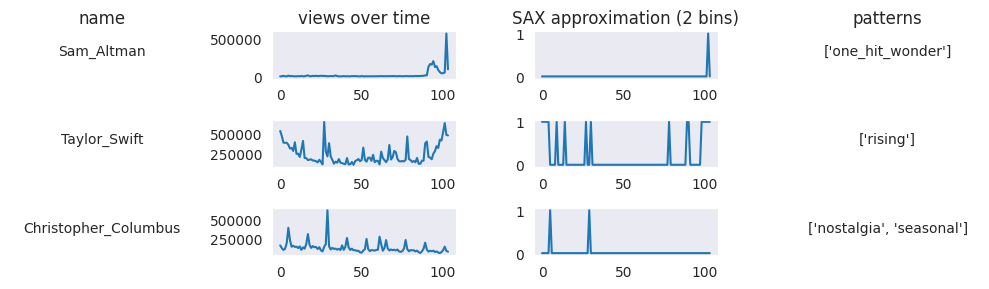

In [481]:
fig, axs = plt.subplots(len(X), 4, figsize=(10, len(X)))

axs[0][0].set(title='name')
axs[0][1].set(title='views over time')
axs[0][2].set(title='SAX approximation (2 bins)')
axs[0][3].set(title='patterns')


all_X = zip(X, X_sax, X_names)
for (x, x_sax, name), ax in zip(all_X, axs):
    ax[0].text(0.5, 0.5, name, ha='center')
    ax[0].axis('off')
    ax[1].plot(x)
    ax[2].plot(x_sax)
    ax[3].text(0.5, 0.5, get_patterns_by_name(name, all_info), ha='center')
    ax[3].axis('off')

    
plt.tight_layout()
plt.show()

# Distributions Analysis

In [203]:
from natsort import natsort_keygen

In [374]:
def patterns_counts_by_columns(columns: str | list[str], normalize: bool, info_df=all_info, sort_by=None, natsort=True):
    counts = (info_df
              .group_by(columns)
              .agg([pl.col(c).sum() for c in all_info.columns if c.startswith('is_')])
              .to_pandas())
    if columns is None:
        counts = counts.drop(columns=['literal'])
    else:
        counts = counts.set_index(columns, drop=True)
        if normalize:
            counts = counts.div(counts.sum(1), 0)
        if sort_by is None:
            counts = counts.sort_index(ascending=False, key=natsort_keygen() if natsort else None)
        else:
            counts = counts.sort_values(sort_by, ascending=False)
            
    return counts

In [376]:
def plot_patterns_by_column(column: str, info_df=all_info, normalize: bool = True, figsize=(8, 2), sort_by=None, natsort=True, **barh_kwargs):
    df_to_plot = patterns_counts_by_columns(column, normalize=normalize, info_df=info_df, natsort=natsort, sort_by=sort_by)
    ax = df_to_plot.plot.barh(stacked=True, cmap='viridis', figsize=figsize, **barh_kwargs)
    sns.move_legend(ax, 'center right', bbox_to_anchor=(1.4, 0.5))

distribution over the entire dataset

/tmp/ipykernel_3751269/3063832332.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot({k: v[0] for k, v in (patterns_counts_by_columns(None, False)).to_dict().items()}, orient='y', palette='viridis')


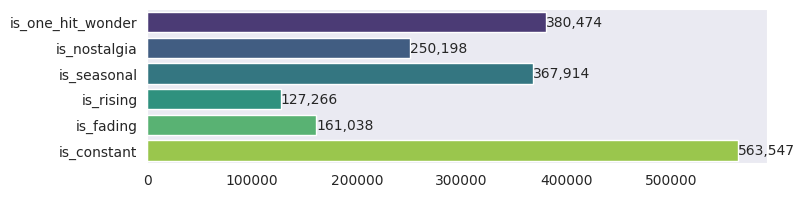

In [482]:
plt.figure(figsize=(8, 2))
ax = sns.barplot({k: v[0] for k, v in (patterns_counts_by_columns(None, False)).to_dict().items()}, orient='y', palette='viridis')
for i in ax.containers:
    ax.bar_label(i, fmt='{:,.0f}')
plt.savefig('../figures/global_distribution.png', bbox_inches='tight')
plt.show()

In [438]:
global_proportions = patterns_counts_by_columns(None, False) / patterns_counts_by_columns(None, False).sum().sum()
global_proportions

,is_one_hit_wonder,is_nostalgia,is_seasonal,is_rising,is_fading,is_constant
0,0.205613,0.13521,0.198825,0.068776,0.087027,0.304548


distribution by gender

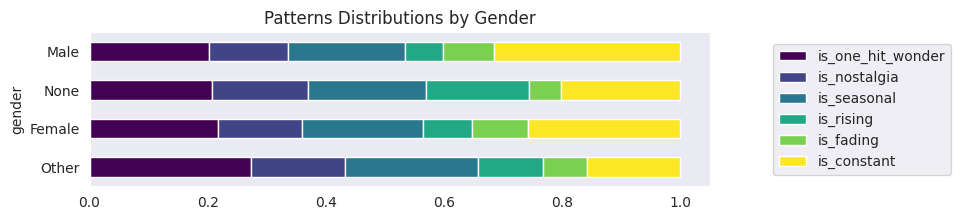

In [364]:
plot_patterns_by_column('gender', sort_by='is_one_hit_wonder')
plt.title('Patterns Distributions by Gender')
plt.savefig('../figures/genders.png', bbox_inches='tight')
plt.show()

Is there a significant difference between the genders?

In [208]:
from statsmodels.stats.proportion import proportions_ztest, proportions_chisquare

def proportions_test(df: pd.DataFrame, row1, row2, col, alternative):
  count = df[col].loc[[row1, row2]].to_numpy()
  nobs = df.loc[[row1, row2]].sum(axis=1).to_numpy()
  # print(count, nobs)
  return proportions_ztest(count=count, nobs=nobs, alternative=alternative)[1]

def proportions_chi2_test(df: pd.DataFrame, rows, col):
  count = df[col].loc[rows].to_numpy()
  nobs = df.loc[rows].sum(axis=1).to_numpy()
  # print(count, nobs)
  return proportions_chisquare(count=count, nobs=nobs)[1]

In [389]:
for col in patterns_counts_by_columns('gender', False).columns:
    print(col, proportions_test(patterns_counts_by_columns('gender', False), 'Male', 'Female', col, 'smaller'))

is_one_hit_wonder 7.718721437021499e-75

is_nostalgia 4.975236794853926e-56

is_seasonal 3.792667141385904e-18

is_rising 0.0

is_fading 2.3271891696114788e-66

is_constant 1.0

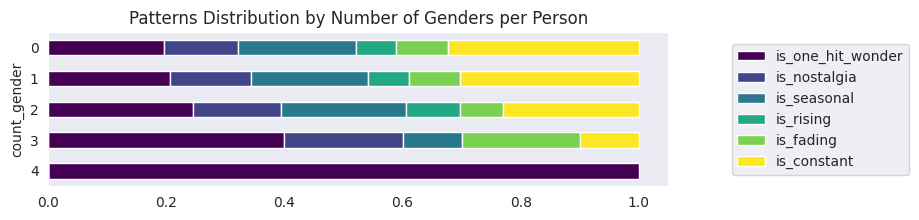

In [365]:
plot_patterns_by_column('count_gender', all_info.fill_null(0))
plt.title('Patterns Distribution by Number of Genders per Person');
plt.savefig('../figures/genders_count.png', bbox_inches='tight')
plt.show()

In [211]:
for col in patterns_counts_by_columns('count_gender', False, all_info.fill_null(0)).columns[1:]:
    print(col, proportions_chi2_test(patterns_counts_by_columns('count_gender', False, all_info.fill_null(0)),
                                     [0, 2, 3, 4], col))

is_nostalgia 0.2830436834211253

is_seasonal 0.9390432068533496

is_rising 0.9654501798116665

is_fading 0.7276153578584192

is_constant 0.0030718438810007635

Distribution by occupation

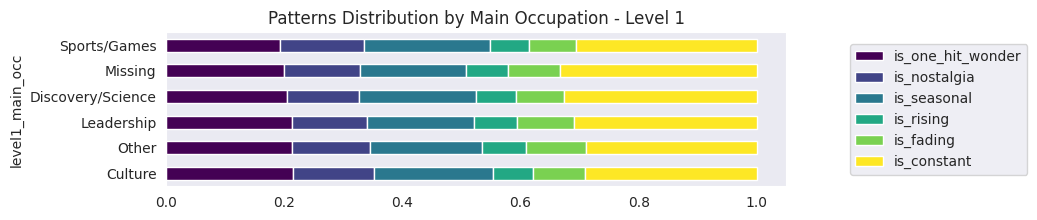

In [366]:
plot_patterns_by_column('level1_main_occ', sort_by='is_one_hit_wonder')
plt.title('Patterns Distribution by Main Occupation - Level 1')
plt.savefig('../figures/occupation_1.png', bbox_inches='tight')
plt.show()

In [213]:
rows = np.array(['Culture', 'Discovery/Science', 'Leadership', 'Missing', 'Other', 'Sports/Games'])
for col in patterns_counts_by_columns('level1_main_occ', False).columns[1:]:
    print(col, proportions_chi2_test(patterns_counts_by_columns('level1_main_occ', False),
                                     rows[[1, 2]], col))

is_nostalgia 1.1159284524714106e-16

is_seasonal 3.965070885587325e-95

is_rising 0.00026378926892071356

is_fading 5.774502791296465e-31

is_constant 2.3098611203638966e-14

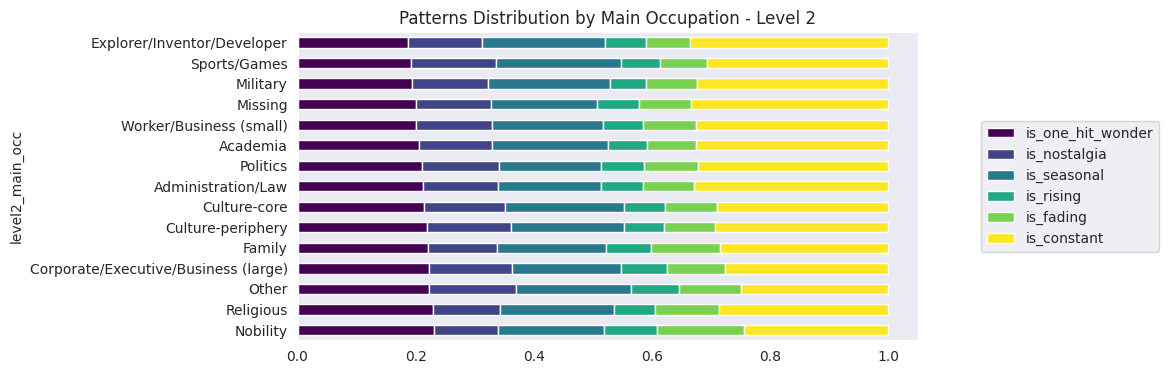

In [367]:
plot_patterns_by_column('level2_main_occ', figsize=(8, 4), sort_by='is_one_hit_wonder')
plt.title('Patterns Distribution by Main Occupation - Level 2')
plt.savefig('../figures/occupation_2.png', bbox_inches='tight')
plt.show()

In [426]:
df = patterns_counts_by_columns('level2_main_occ', False)

different = {}
same = {}

for col in df.columns[:-1]:
    for row1, row2 in combinations_with_replacement(df.index.tolist(), r=2):
        if row1 == row2:
            continue
        pv = proportions_test(df, row1, row2, col, 'two-sided')
        if pv > .05:
            same[col] = same.get(col, 0) + 1
        else:
            different[col] = different.get(col, 0) + 1
print(same, different)
print(f'percent different: {sum(different.values()) / 600}')

{'is_one_hit_wonder': 21, 'is_nostalgia': 25, 'is_seasonal': 25, 'is_rising': 35, 'is_fading': 19}
{'is_one_hit_wonder': 84, 'is_nostalgia': 80, 'is_seasonal': 80, 'is_rising': 70, 'is_fading': 86}

percent different: 0.6666666666666666

Birth period

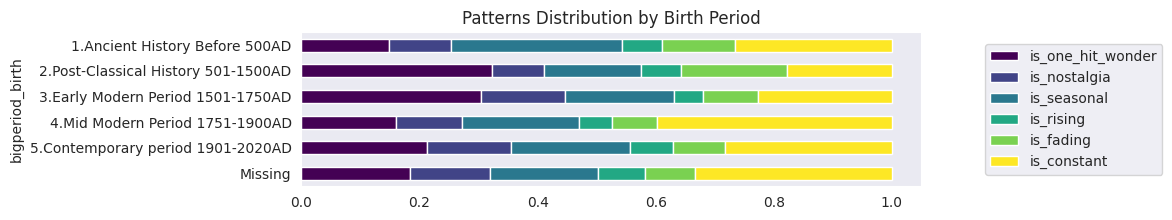

In [378]:
plot_patterns_by_column('bigperiod_birth', natsort=False)
plt.title('Patterns Distribution by Birth Period')
plt.savefig('../figures/birth_period.png', bbox_inches='tight')
plt.show()

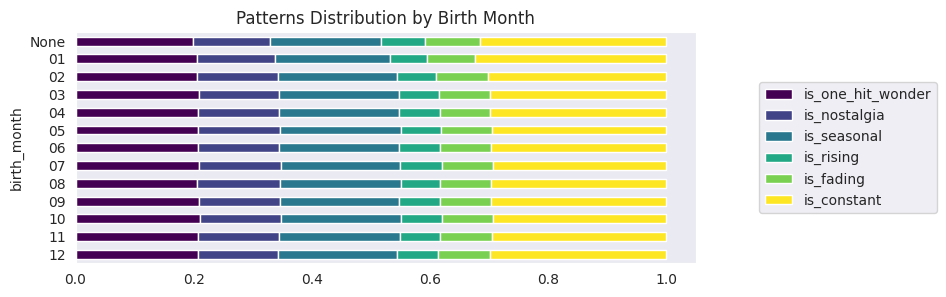

In [379]:
plot_patterns_by_column('birth_month', figsize=(8, 3))
plt.title('Patterns Distribution by Birth Month')
plt.savefig('../figures/birth_month.png', bbox_inches='tight')
plt.show()

Location

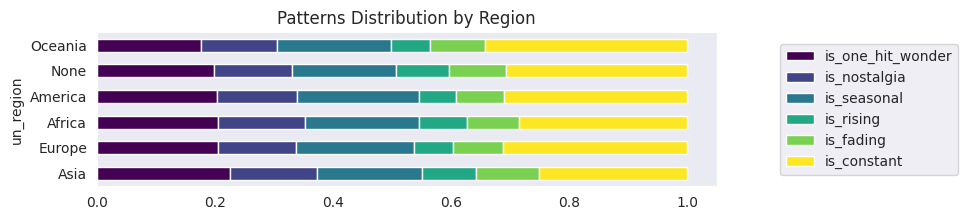

In [380]:
plot_patterns_by_column('un_region', sort_by='is_one_hit_wonder')
plt.title('Patterns Distribution by Region')
plt.savefig('../figures/region.png', bbox_inches='tight')
plt.show()

/tmp/ipykernel_3751269/2528654967.py:3: UserWarning: Glyph 128 (\x80) missing from current font.
  plt.savefig('../figures/citizenship.png', bbox_inches='tight')
/tmp/ipykernel_3751269/2528654967.py:3: UserWarning: Glyph 147 (\x93) missing from current font.
  plt.savefig('../figures/citizenship.png', bbox_inches='tight')
/home/netanel/.conda/envs/big_data_project/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/netanel/.conda/envs/big_data_project/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


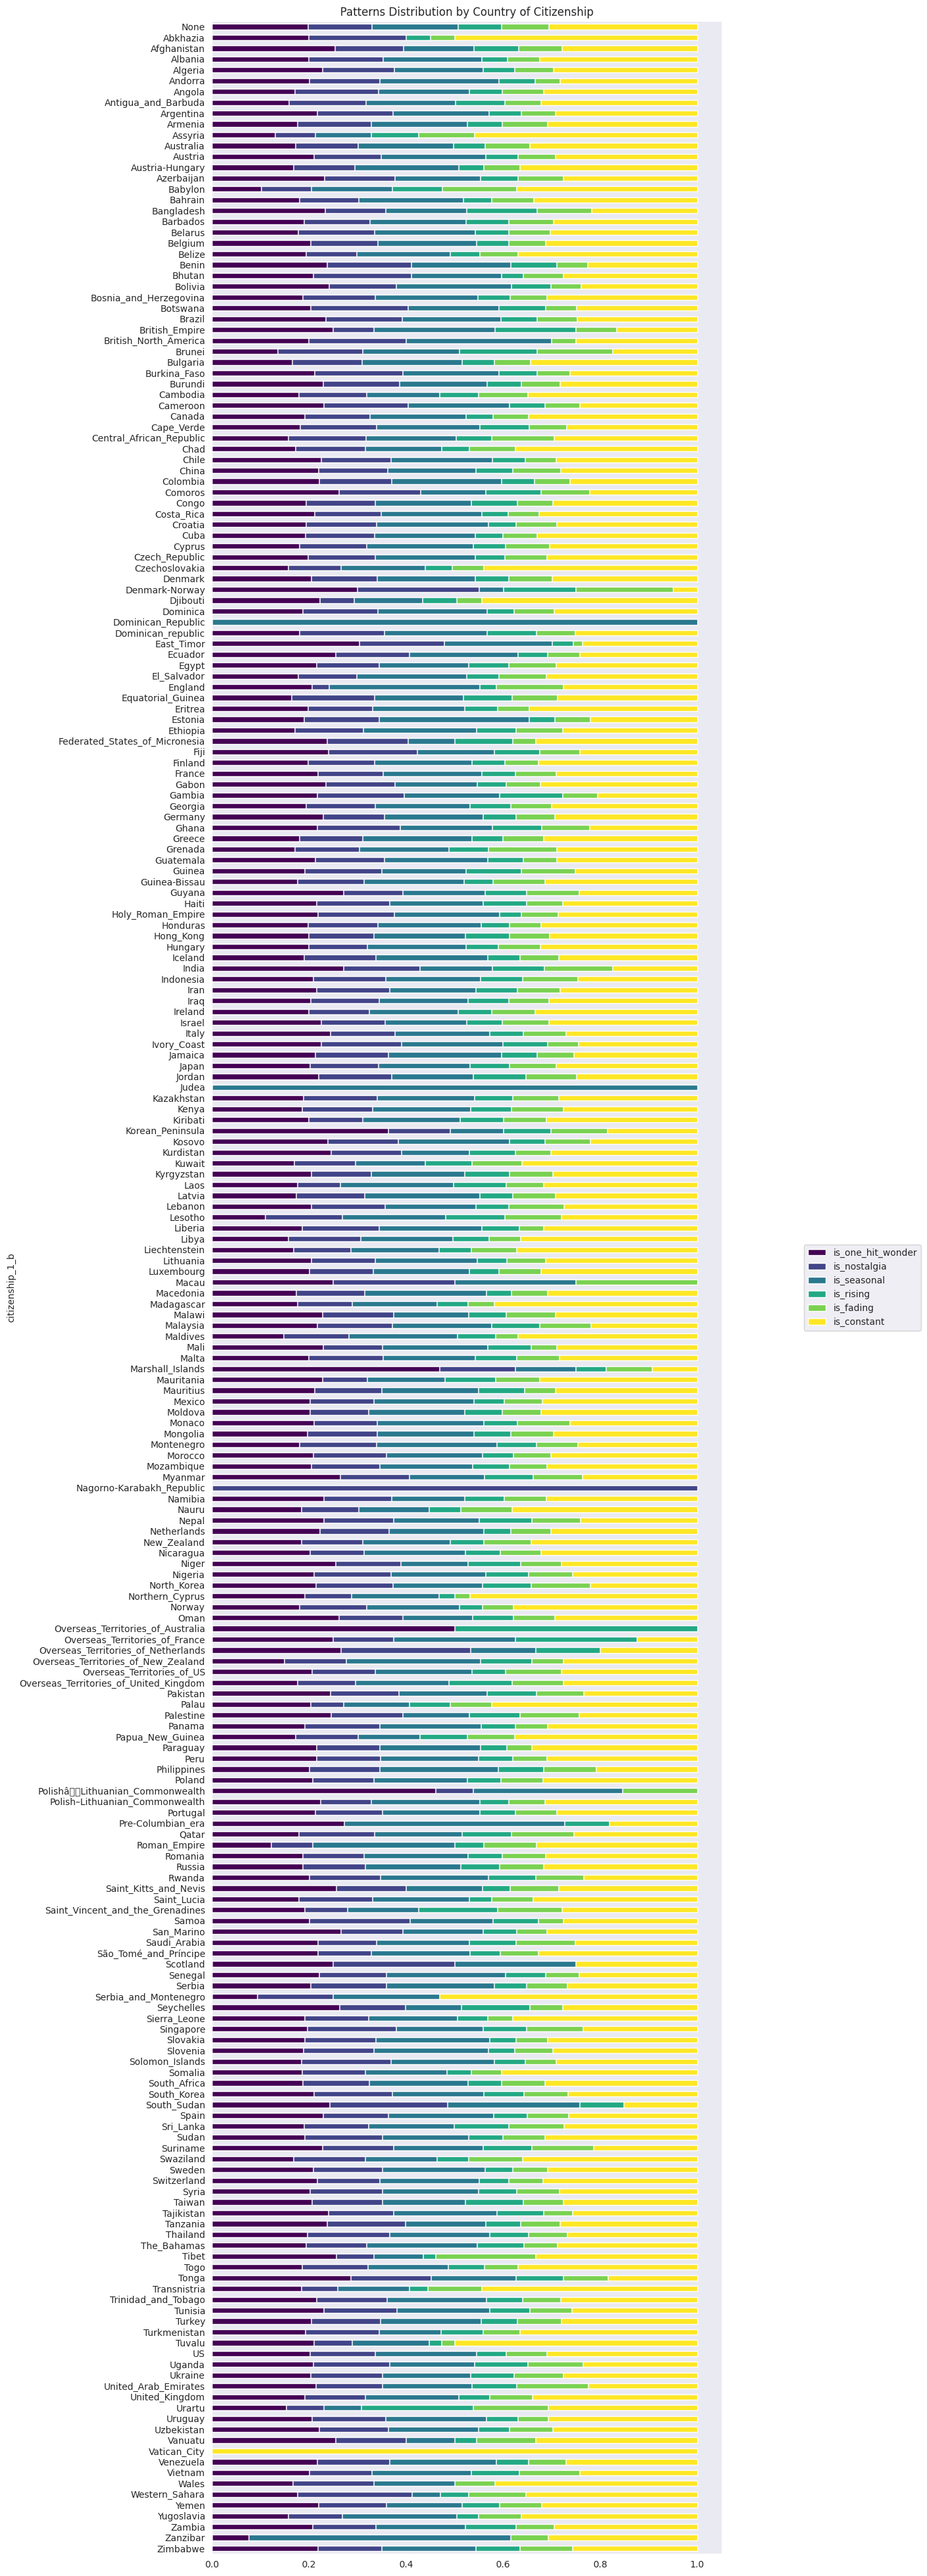

In [381]:
plot_patterns_by_column('citizenship_1_b', figsize=(10, 50))
plt.title('Patterns Distribution by Country of Citizenship')
plt.savefig('../figures/citizenship.png', bbox_inches='tight')
plt.show()

eduacted at

In [383]:
def plot_patterns_by_list_column(column, info_df=all_info, normalize: bool = True, figsize=(8, 10), slice_range=(1, 50)):
    numeric_cols = [col for col in info_df.columns if col.startswith('is_')]
    cols = [column] + numeric_cols
    df = (info_df[cols].explode(column)
          .group_by(column).agg([pl.col(col).sum() for col in info_df.columns if col.startswith('is_')])
          .sort(pl.sum_horizontal(numeric_cols), descending=True)
          .to_pandas()
          .iloc[slice_range[0]:slice_range[1]]
          .set_index(column, drop=True)
          
    )
          
    if normalize:
        df = df.div(df.sum(1), 0).sort_values('is_one_hit_wonder', ascending=False)
        
    ax = df.plot.barh(stacked=True, cmap='viridis', figsize=figsize)
    sns.move_legend(ax, 'center right', bbox_to_anchor=(1.4, 0.5))

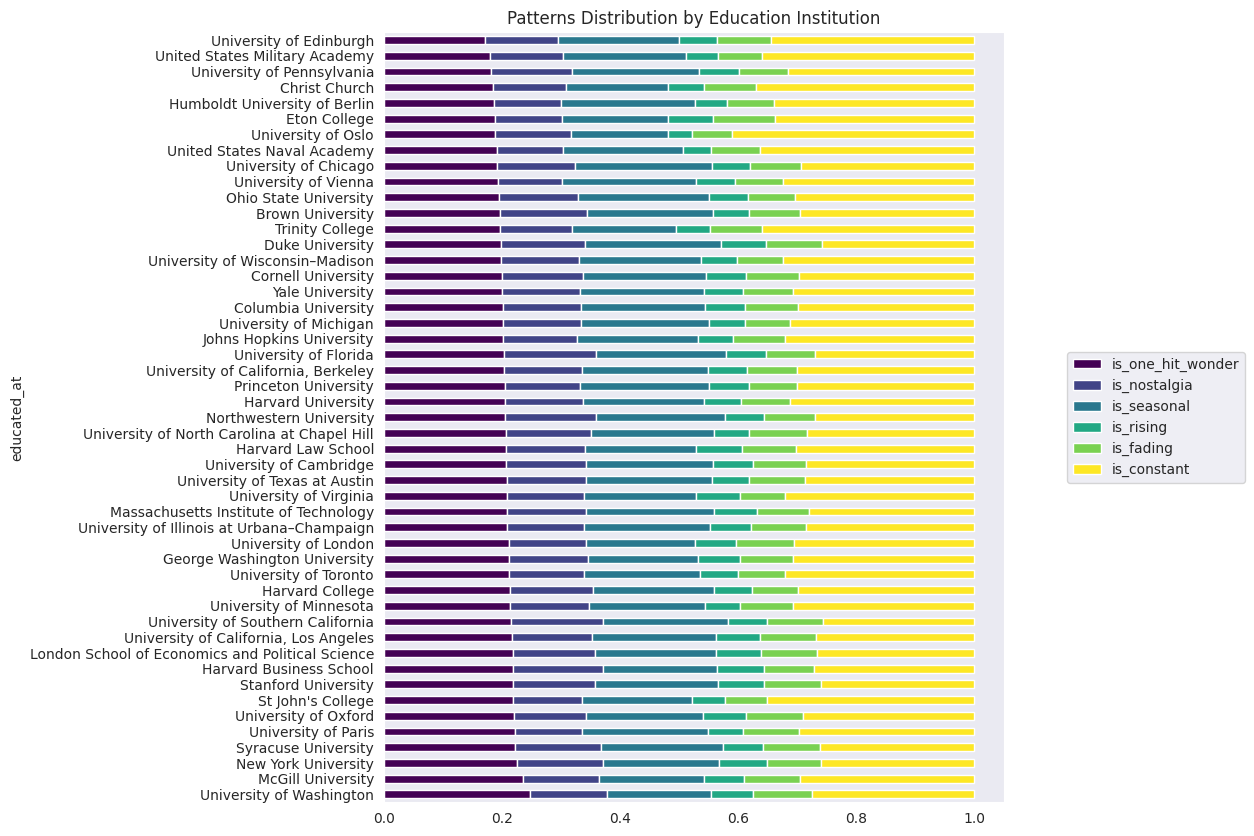

In [384]:
plot_patterns_by_list_column('educated_at')
plt.title('Patterns Distribution by Education Institution')
plt.savefig('../figures/educated_at.png', bbox_inches='tight')
plt.show()

notability rank

In [485]:
df_rank = (all_info.select([col for col in all_info.columns if col.startswith('is_')] + [pl.col('ranking_visib_5criteria').alias('rank')])
            .sort('rank'))
quantiles = list(np.linspace(0.1, 1, 10))
df_rank = df_rank.with_columns(pl.col('rank').qcut(quantiles, labels=[str(i + 1) for i in range(len(quantiles) + 1)]).alias('bin').cast(pl.String))
df_rank

is_one_hit_wonder,is_nostalgia,is_seasonal,is_rising,is_fading,is_constant,rank,bin
bool,bool,bool,bool,bool,bool,f64,str
false,true,false,false,false,false,1.0,"""1"""
false,false,true,false,false,false,2.0,"""1"""
false,false,true,false,false,false,3.0,"""1"""
false,false,true,false,false,false,4.0,"""1"""
false,false,true,false,false,false,5.0,"""1"""
…,…,…,…,…,…,…,…
false,false,false,false,false,true,3.224123e6,"""10"""
true,false,false,true,false,false,3.238915e6,"""10"""
false,true,true,false,false,false,3.242352e6,"""10"""


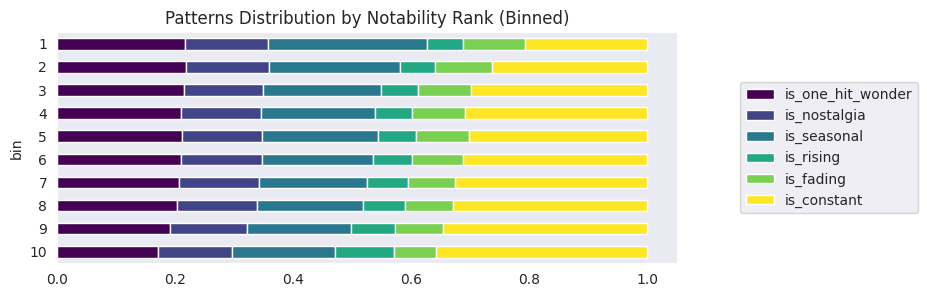

In [487]:
plot_patterns_by_column('bin', info_df=df_rank, figsize=(8, 3))
plt.title('Patterns Distribution by Notability Rank (Binned)')
plt.savefig('../figures/notability.png', bbox_inches='tight')
plt.show()

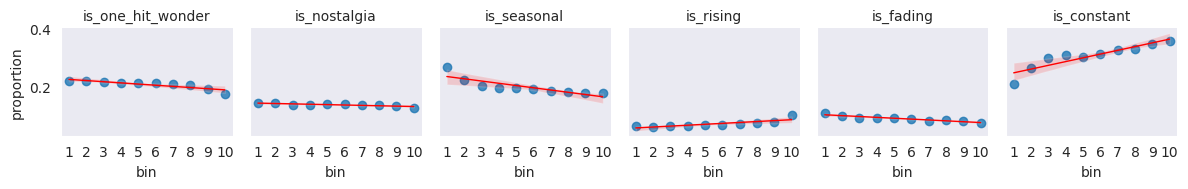

In [547]:
df = patterns_counts_by_columns('bin', info_df=df_rank, normalize=True).melt(ignore_index=False).reset_index().astype({'bin': int})
g = sns.FacetGrid(df, col='variable', col_wrap=6, sharex=False, sharey=True, height=2, margin_titles=True)
g.set_titles(col_template='{col_name}')
g.set(xticks=range(11))
g.map_dataframe(sns.regplot, x='bin', y='value', line_kws=dict(color='red', lw=1))
g.set_ylabels('proportion')
